In [ ]:
#mounting the google drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#importing required libraries 
import cv2
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import random
import zipfile
import math
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, RepeatVector,Reshape, Activation, Dense, Dropout, Flatten, Input, Add
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from sklearn.model_selection import train_test_split
from skimage.color import rgb2gray, gray2rgb, rgb2lab, lab2rgb
from skimage.io import imsave
from skimage import filters

In [ ]:
# Extract Dataset
data_path = "/content/drive/MyDrive/summerproject-2021/PGsir/Copy of  Train256.zip"
zip_ref = zipfile.ZipFile(data_path, 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [ ]:
#useful functions

#loading images from the given directory and store in numpy array 
def load_img_to_array(dir_path):
  images = []
  for filename in sorted(os.listdir(dir_path)):
    img = img_to_array(load_img(dir_path+os.sep+filename))
    img = cv2.resize(img,(256,256))
    images.append(img)
  return np.array(images,dtype='int')

#scale the image - normalization
def scale(img):
  img-=np.min(img)
  img/=np.max(img)
  return np.array([i*255 for i in img])

#making the image blur by guassian blur
def make_blur(images, sig):
  ans = []
  for img in images:
    ans.append(scale(filters.gaussian(img, sigma=sig)))
  return np.array(ans, dtype='int')

def make_blur_random(images):
  ans = []
  for img in images:
    sig = random.randint(0, 30)/10
    ans.append(scale(filters.gaussian(img, sigma=sig)))
  return np.array(ans, dtype='int')
  
#calculating PSNR
def psnr(img1, img2):
  mse = np.mean( (img1 - img2) ** 2 )
  if mse == 0:
    return 100
  PIXEL_MAX = 255.0
  return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

In [ ]:
#prepare flowers dataset 
Y = load_img_to_array('/tmp/Train')
X = make_blur_random(Y)
#split the dataset to train and validation
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1,random_state = 42)
X_train.shape,X_val.shape

#prepare gopro dataset 

# X = load_img_to_array('/tmp/goprosmall/blur')
# Y = load_img_to_array('/tmp/goprosmall/sharp')

#split the dataset to train and validation

# X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.1,random_state = 42)
# X_train.shape,X_val.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.


((1080, 256, 256, 3), (120, 256, 256, 3))

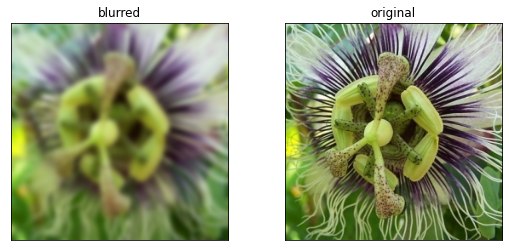

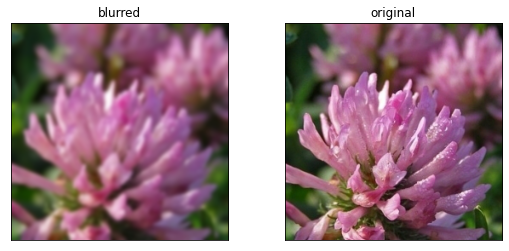

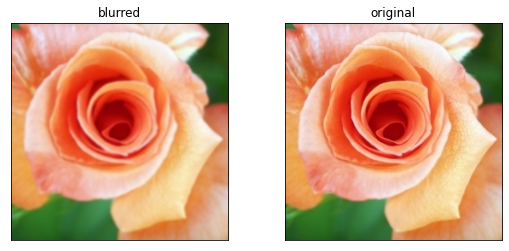

In [ ]:
#preview of flower dataset

X_prev = [X_train[1],X_train[24],X_train[38]]
Y_prev = [Y_train[1],Y_train[24],Y_train[38]]
preds = []
for i in range(3):
  fig,(ax1,ax2) = plt.subplots(1,2) 
  fig.set_size_inches(9,4)                        
  ax1.imshow((X_prev[i]))
  ax2.imshow(Y_prev[i])
  ax1.set_title('blurred')
  ax2.set_title('original')
  ax1.set_xticks([]),ax2.set_xticks([])
  ax1.set_yticks([]),ax2.set_yticks([])
  plt.show()

In [ ]:
# np.save("/content/drive/MyDrive/summerproject-2021/PGsir/flower_random_X.npy", X_train)
# np.save("/content/drive/MyDrive/summerproject-2021/PGsir/flower_random_Y.npy", Y_train)
X_train = np.load("/content/drive/MyDrive/summerproject-2021/PGsir/flower_random_X.npy")
Y_train = np.load("/content/drive/MyDrive/summerproject-2021/PGsir/flower_random_Y.npy")



In [ ]:
#function for dense block which is used multiple times  
def dense_block(input):
    li = []
    con = input
    c1 = Conv2D(16,(3,3),strides=1,padding='same',activation='relu')(con)
    li.append(c1)
    for i in range(7):
        con = layers.Concatenate(axis=3)(li)
        c1 = Conv2D(16,(3,3),strides=1,padding='same',activation='relu')(con)
        li.append(c1)
    output = layers.Concatenate(axis=3)(li)
    return output

In [ ]:
def dense_net(lr =1e-4):
    input = Input(shape=(256,256,3))

    low_lvl = Conv2D(16 ,strides=2, kernel_size=(3,3),activation='relu',padding='SAME')(input)

    li = []
    li.append(low_lvl)

    dense1 = dense_block(low_lvl)
    li.append(dense1)
    dense2 = dense_block(dense1)
    li.append(dense2)
    dense3 = dense_block(dense2)
    li.append(dense3)
    dense4 = dense_block(dense3)
    li.append(dense4)
    dense5 = dense_block(dense4)
    li.append(dense5)
    dense6 = dense_block(dense5)
    li.append(dense6)
    dense7 = dense_block(dense6)
    li.append(dense7)
    dense8 = dense_block(dense7)
    li.append(dense8)

    con = layers.Concatenate(axis=3)(li)

    bot = Conv2D(256,(1,1),activation='relu')(con)

    deconv = Conv2DTranspose(256,(3,3),strides=2,activation='relu',padding='same')(bot)
    deconv = Conv2DTranspose(256,(3,3),strides=1,activation='relu',padding='same')(deconv)

    recons = Conv2D(3,(3,3),padding='same', activation='relu')(deconv)

    model = Model(inputs =[input],outputs =[recons])

    model.compile(
        loss = tf.keras.losses.MeanSquaredError(),
        optimizer =tf.keras.optimizers.Adam(learning_rate=lr),
        metrics =['accuracy']
    )

    return model


In [ ]:
MODEL=dense_net()
#MODEL.summary()

In [ ]:
tf.keras.utils.plot_model(MODEL,show_shapes=True)

In [ ]:
# Build Model
MODEL = dense_net(lr = 0.0001)

#log Callback
reducelr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',min_lr=0.00001,factor=0.75,patience=4,verbose=1)
csvlog = tf.keras.callbacks.CSVLogger("/content/drive/MyDrive/summerproject-2021/PGsir/logs/sr_dense-flower_ds_random.csv",append=True, separator=',')
callbacks = [reducelr, csvlog]

#loading log file
start_epoch = 0
try:
  log_df = pd.read_csv('/content/drive/MyDrive/summerproject-2021/PGsir/logs/sr_dense-flower_ds_random.csv')
  start_epoch = len(log_df['epoch'])
except:
  try:
    del(log_df)
  except:
    pass

# Load Weights
try:
  MODEL.load_weights("/content/drive/MyDrive/summerproject-2021/PGsir/sr_dense-flower_ds_random.h5")
except:
  pass


#Batch generation
datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

batchGen = datagen.flow(x=X_train, y=Y_train, batch_size=16)
#valBatchGen = val_datagen.flow(x=X_val, y=Y_val, batch_size=8)

# Training
MODEL.fit(batchGen, epochs=20, callbacks=callbacks, initial_epoch = start_epoch)
# Save Model Weights
MODEL.save('/content/drive/MyDrive/summerproject-2021/PGsir/sr_dense-flower_ds_random.h5')


Epoch 1/20
68/68 [==============================] - 181s 2s/step - loss: 2948.8167 - accuracy: 0.5023
Epoch 2/20
68/68 [==============================] - 132s 2s/step - loss: 426.1660 - accuracy: 0.8329
Epoch 3/20
68/68 [==============================] - 134s 2s/step - loss: 301.3481 - accuracy: 0.8880
Epoch 4/20
68/68 [==============================] - 136s 2s/step - loss: 266.8011 - accuracy: 0.8905
Epoch 5/20
68/68 [==============================] - 138s 2s/step - loss: 251.4238 - accuracy: 0.9036
Epoch 6/20
68/68 [==============================] - 138s 2s/step - loss: 238.0289 - accuracy: 0.9115
Epoch 7/20
68/68 [==============================] - 138s 2s/step - loss: 227.8462 - accuracy: 0.9122
Epoch 8/20
68/68 [==============================] - 138s 2s/step - loss: 216.9082 - accuracy: 0.9155
Epoch 9/20
68/68 [==============================] - 138s 2s/step - loss: 208.8963 - accuracy: 0.9173
Epoch 10/20
68/68 [==============================] - 139s 2s/step - loss: 204.6976 - accur

In [ ]:
#MODEL.load_weights("/content/drive/MyDrive/summerproject-2021/PGsir/sr_dense.h5")
MODEL.load_weights("/content/drive/MyDrive/summerproject-2021/PGsir/sr_dense-flower_ds_random.h5")

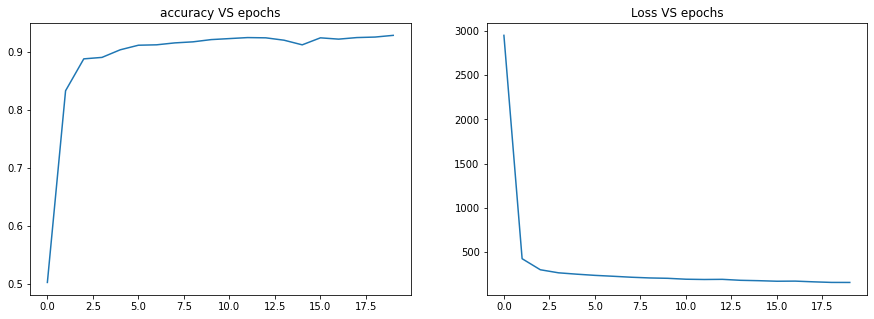

In [ ]:
log_df = pd.read_csv('/content/drive/MyDrive/summerproject-2021/PGsir/logs/sr_dense-flower_ds_random.csv')
fig,(ax1,ax2)=plt.subplots(1,2)
fig.set_size_inches(15,5)
ax1.plot(log_df['epoch'],log_df['accuracy'])
ax2.plot(log_df['epoch'],log_df['loss'])
ax1.set_title('accuracy VS epochs')
ax2.set_title('Loss VS epochs')
plt.show()

PSNR value of Prediction and Ground Truth - 20.04 dB


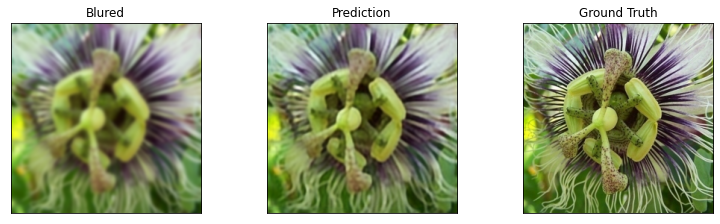

PSNR value of Prediction and Ground Truth - 26.13 dB


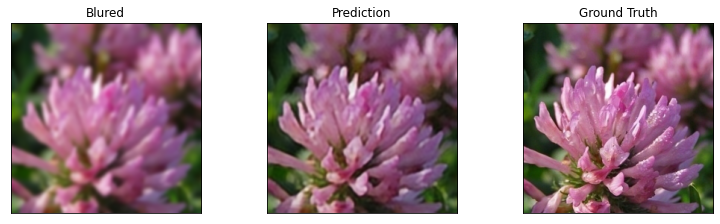

PSNR value of Prediction and Ground Truth - 19.96 dB


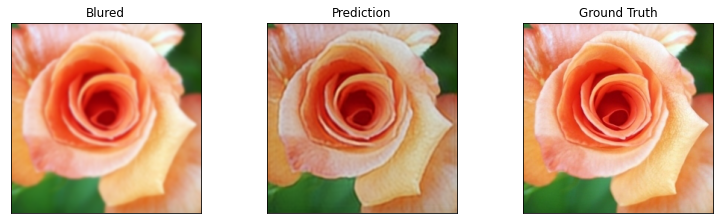

In [ ]:
test = [X_train[1],X_train[24],X_train[38]]
ori= [Y_train[1],Y_train[24],Y_train[38]]
preds = []
for i in range(3):
  fig,(ax1,ax2,ax3) = plt.subplots(1,3) 
  fig.set_size_inches(13,3.5)
  pred = MODEL.predict(test[i].reshape(1,256,256,3))
  preds.append(pred) 
  t = scale(pred[0]) 
  d=psnr(ori[i],t)
  print("PSNR value of Prediction and Ground Truth -", "%.2f" % d, "dB")                  
  ax1.imshow((test[i]))

  ax2.imshow(t/255)
  ax3.imshow(ori[i])
  ax1.set_title('Blured')
  ax2.set_title('Prediction')
  ax3.set_title('Ground Truth')
  ax1.set_xticks([]),ax2.set_xticks([]),ax3.set_xticks([])
  ax1.set_yticks([]),ax2.set_yticks([]),ax3.set_yticks([])
  # plt.savefig("/content/drive/MyDrive/Datasets/Outputs/img_"+str(datetime.now())+'.png')
  plt.show()


In [ ]:
test_x = load_img_to_array('/content/drive/MyDrive/summerproject-2021/PGsir/blurred_notes')
# test_x = make_blur(test_y,2)

In [ ]:
test_pred = MODEL.predict(test_x)


PSNR value of Prediction and Ground Truth - 9.06 dB


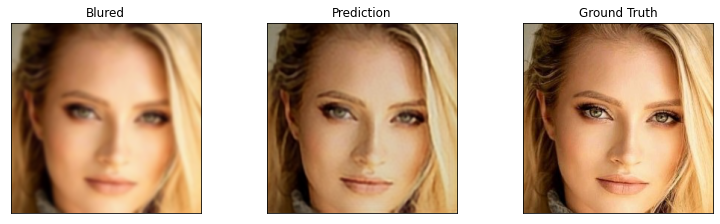

PSNR value of Prediction and Ground Truth - 10.14 dB


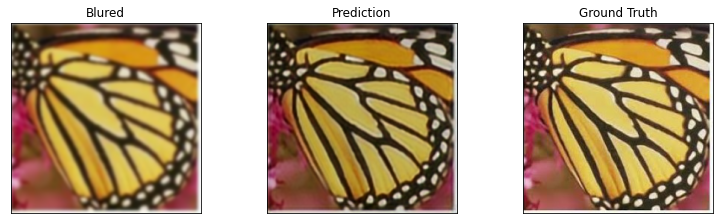

In [ ]:
for i in range(2):
  fig,(ax1,ax2,ax3) = plt.subplots(1,3) 
  fig.set_size_inches(13,3.5)
  t = scale(test_pred[1-i]) 
  d=psnr(ori[i],t)
  print("PSNR value of Prediction and Ground Truth -", "%.2f" % d, "dB")   
  ax1.imshow((test_x[1-i]))
  ax2.imshow(t/255)
  ax3.imshow(test_y[1-i])
  ax1.set_title('Blured')
  ax2.set_title('Prediction')
  ax3.set_title('Ground Truth')
  ax1.set_xticks([]),ax2.set_xticks([]),ax3.set_xticks([])
  ax1.set_yticks([]),ax2.set_yticks([]),ax3.set_yticks([])
  # plt.savefig("/content/drive/MyDrive/Datasets/Outputs/img_"+str(datetime.now())+'.png')
  plt.show()


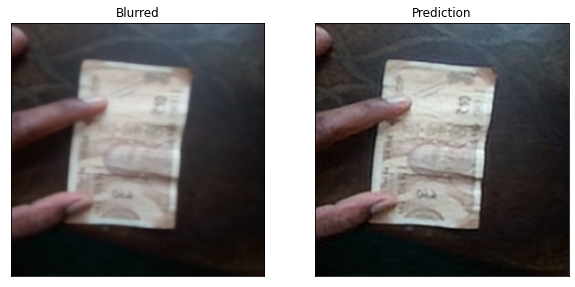

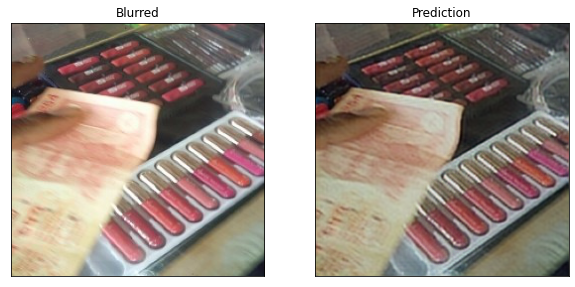

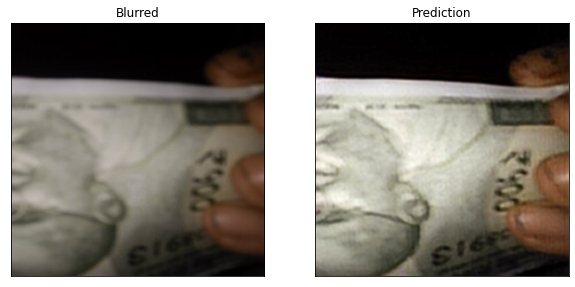

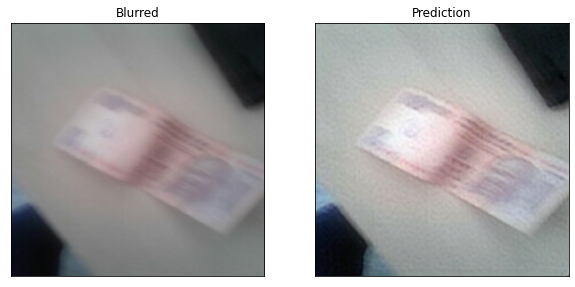

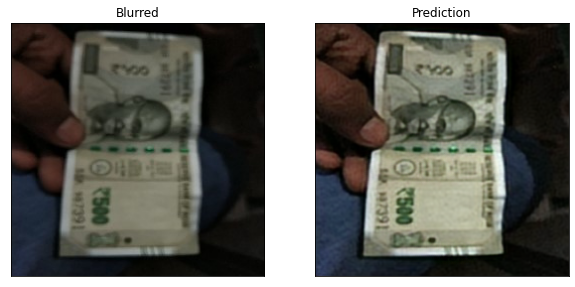

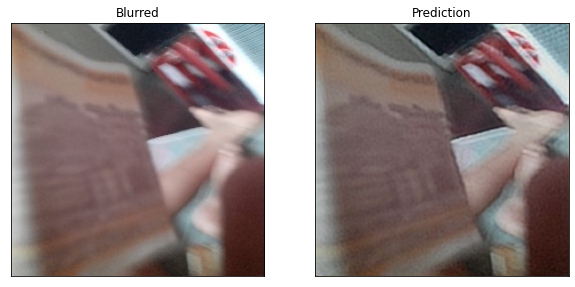

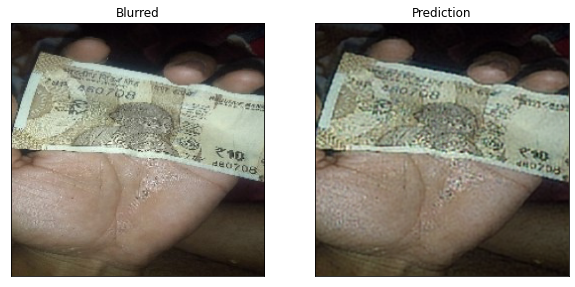

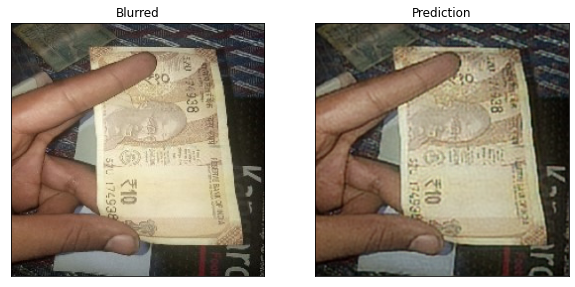

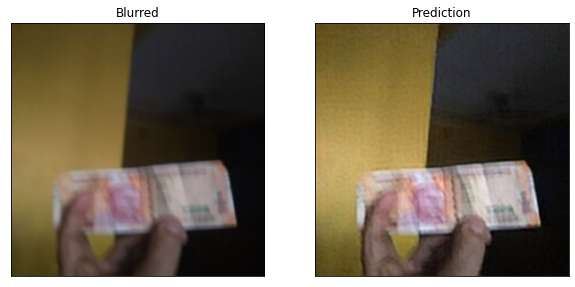

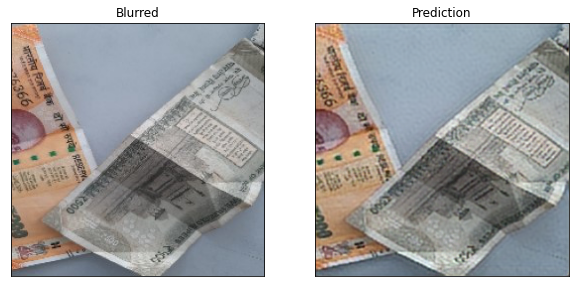

In [ ]:
for i in range(10):
  fig,(ax1,ax2) = plt.subplots(1,2) 
  fig.set_size_inches(10,5)
  t = scale(test_pred[i])  
  ax1.imshow((test_x[i]))
  ax2.imshow(t/255)
  ax1.set_title('Blurred')
  ax2.set_title('Prediction')
  ax1.set_xticks([]),ax2.set_xticks([])
  ax1.set_yticks([]),ax2.set_yticks([])
  # plt.savefig("/content/drive/MyDrive/Datasets/Outputs/img_"+str(datetime.now())+'.png')
  plt.show()